## Prepare input for Brink code for Lab runs

* Shelf and axis profiles
* Stratification
* Input to all answers in code set up

Structure and snippets from Idalia's notebook ([https://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/analysis_mackenzie_canyon/raw/tip/notebooks/general_circulation/Brink_program.ipynb])

In [22]:
import cmocean as cmo
import gsw
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy as sc, scipy.io
from scipy import interpolate
from scipy.interpolate import interp1d
import scipy.io as sio

import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
%matplotlib inline

In [23]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density in the water column using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be either arrays or scalars (if arrays, in coordinate order (...,Z, Y , X )) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...]) + beta*(S[...]))
    return rho

def calc_N2_lab(RhoRef,rho,drC):
    '''INPUT:
    RhoRef: reference density (scalar)
    rho: density (1D array)
    drC: vertical spacing between 
    OUTPUT:
    N2: buoyancy frequency squared (1D array size nz-2)'''
    
    g = 9.81 # m/s^2
    N2 = ((-g/RhoRef)*((rho[2:] - rho[:-2])/(drC[2:]+drC[:-2])))            
    return(N2)

### 1. Shelf profile

In [24]:
bat_file = 'BathySpacing01.nc'
bathy = Dataset(bat_file)
depth = bathy['Bathymetry'][:]
X = bathy['X'][:]
Y = bathy['Y'][:]

ins_file = 'BathyInsert03.nc'
bathy_ins = Dataset(ins_file)
depth_ins = bathy_ins['Bathymetry'][:]
X_ins = bathy_ins['X'][:]
Y_ins = bathy_ins['Y'][:]

In [25]:
bathy

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Spacing bathymetry 01
    author: Karina Ramos Musalem
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: bitbucket.org/CanyonsUBC/BuildCanyon/Bathymetry/GenerateTankBathymetry_Inserts.ipynb
    description: Spacing bathymetry for 3D printing. Make into stl file. Three of these make up for all the space between 2 canyon inserts
    timeStamp: Fri Sep 14 14:29:35 2018
    dimensions(sizes): x(200), y(200)
    variables(dimensions): float64 X(y,x), float64 Y(y,x), float64 Bathymetry(y,x)
    groups: 

Text(0.5,0,'Cross-shelf distance / m')

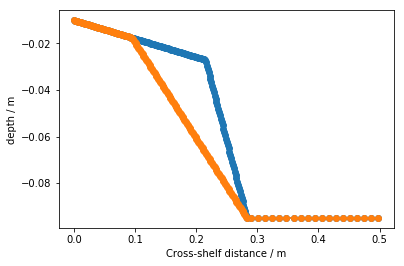

In [26]:
x_shelf = np.abs(np.flipud(X[0,:]-X[0,-1]))
x_ext = np.append(np.abs(np.flipud(X[0,:]-X[0,-1])), [np.linspace(x_shelf[-1]+0.007,x_shelf[-1]+0.215,19)])
depth_shelf = np.append(np.flipud(depth[0,:]-0.095), -0.095*np.ones(19)) # 0.095 total depth. Depth at wall is too deep at 1cm

plt.plot(x_ext, depth_shelf,'o-')

x_axis = np.abs(np.flipud(X_ins[0,:]-X_ins[0,-1]))
x_ext_axis = np.append(np.abs(np.flipud(X_ins[0,:]-X_ins[0,-1])), [np.linspace(x_axis[-1]+0.007,x_axis[-1]+0.215,19)])
depth_axis = np.append(np.flipud(depth_ins[100,:]-0.095), -0.095*np.ones(19)) # 0.095 total depth. Depth at wall is too deep at 1cm

plt.plot(x_ext_axis, depth_axis,'o-')
plt.ylabel('depth / m')
plt.xlabel('Cross-shelf distance / m')

In [27]:
# Cross-shelf points for input (depth, distance pairs)
cs_points = 80
x_interp = np.linspace(0,0.50, cs_points)

f_int_shelf = interpolate.interp1d(x_ext, depth_shelf, fill_value='extrapolate')
cs_interp_shelf = np.round(f_int_shelf(x_interp),5)

f_int_axis = interpolate.interp1d(x_ext_axis, depth_axis, fill_value='extrapolate')
cs_interp_axis = np.round(f_int_axis(x_interp),5)

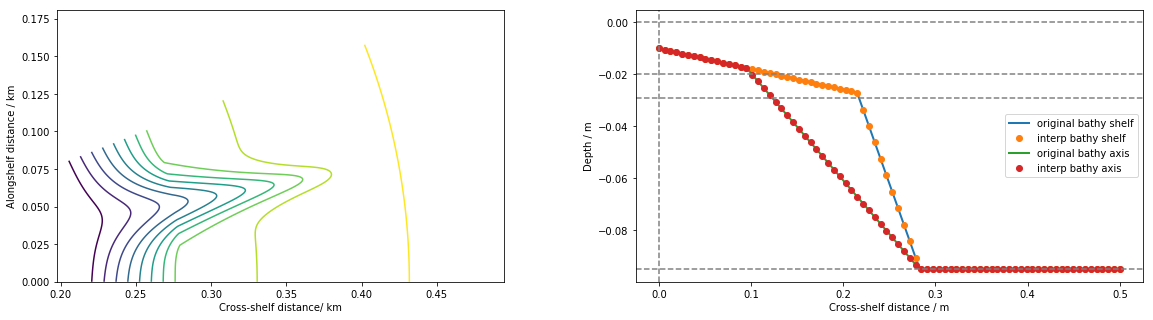

In [28]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].contour(X_ins,Y_ins,depth_ins, 10)
ax[0].set_ylabel('Alongshelf distance / km')
ax[0].set_xlabel('Cross-shelf distance/ km')
ax[0].set_aspect(1)

ax[1].plot(x_ext, depth_shelf, '-', linewidth=2, label='original bathy shelf')
ax[1].plot(x_interp, cs_interp_shelf, 'o', label='interp bathy shelf') # revert because 0 distance has to be at the coast
ax[1].plot(x_ext_axis,depth_axis, '-', linewidth=2, label='original bathy axis')
ax[1].plot(x_interp, cs_interp_axis, 'o', label='interp bathy axis') # revert because 0 distance has to be at the coast

ax[1].axhline(0,color='0.5', linestyle='--')
ax[1].axvline(0,color='0.5', linestyle='--')
ax[1].axhline(-0.095,color='0.5', linestyle='--')
ax[1].axhline(-0.029,color='0.5', linestyle='--')
ax[1].axhline(-0.020,color='0.5', linestyle='--')

ax[1].set_ylabel('Depth / m')
ax[1].set_xlabel('Cross-shelf distance / m')
ax[1].legend()

### 2. Stratification ($N^2$)

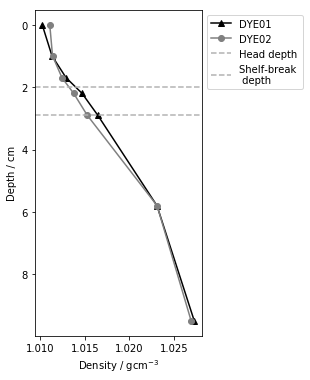

In [29]:
# Samples from DYE01
density1 = np.array([1.01023,1.01133,1.01291,1.0147,1.01646,1.023107,1.0273])
density2 = np.array([1.01108,1.01139,1.01245,1.01376,1.01528,1.02312,1.02695])
depths = np.array([0,1.0,1.7,2.2,2.9,5.8,9.5])

fig, ax = plt.subplots(1,1,figsize=(3,6))
ax.plot(density1, depths, '^-',color='k',label='DYE01')
ax.plot(density2, depths, 'o-',color='0.5', label='DYE02')
ax.axhline(2.9, color='0.7', linestyle='--', label='Head depth')
ax.axhline(2.0, color='0.7', linestyle='--', label='Shelf-break \n depth')
ax.invert_yaxis()
ax.set_xlabel(r'Density / gcm$^{-3}$')
ax.set_ylabel('Depth / cm')
ax.legend(bbox_to_anchor=(1,1))

In [30]:
RhoRef = 999.750 # density bucket 2, fresh water
Rho = density1*1000
dep = -depths/100

In [31]:
# Vertical levels for input and interpolation. Model requires a surface value for N^2.
nlevs = 31
z_interp = np.round(np.linspace(np.min(dep),0, nlevs),4)
z_increment = np.mean(np.abs(z_interp[1:]-z_interp[:-1]))

f_int_dens = interpolate.interp1d(dep, Rho, fill_value='extrapolate')
dens_interp = np.round(f_int_dens(z_interp),12)

N2 = calc_N2_lab(RhoRef,dens_interp[1:],z_interp[1:]-z_interp[:-1])

0 0.0 1.03078
1 -0.0032 1.03078
2 -0.0063 1.03893
3 -0.0095 1.25822
4 -0.0127 1.4462
5 -0.0158 1.62077
6 -0.019 1.81333
7 -0.0222 1.70844
8 -0.0253 1.57071
9 -0.0285 1.55333
10 -0.0317 1.49364
11 -0.0348 1.49969
12 -0.038 1.51155
13 -0.0412 1.48793
14 -0.0443 1.49969
15 -0.0475 1.51155
16 -0.0507 1.48793
17 -0.0538 1.49969
18 -0.057 1.37394
19 -0.0602 1.12796
20 -0.0633 1.05451
21 -0.0665 1.06285
22 -0.0697 1.04624
23 -0.0728 1.05451
24 -0.076 1.06285
25 -0.0792 1.04624
26 -0.0823 1.05451
27 -0.0855 1.06285
28 -0.0887 1.04624
29 -0.0918 1.04624
30 -0.095 1.04624


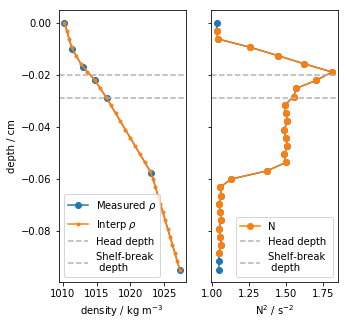

In [32]:
fig, ax = plt.subplots(1,2,figsize=(5,5), sharey=True)

ax[0].plot(Rho, dep, 'o-', label=r'Measured $\rho$')
ax[0].plot(dens_interp, z_interp, '.-',label=r'Interp $\rho$')

ax[0].set_xlabel('density / kg m$^{-3}$')
ax[0].set_ylabel('depth / cm')
ax[0].axhline(-0.029, color='0.7', linestyle='--', label='Head depth')
ax[0].axhline(-0.020, color='0.7', linestyle='--', label='Shelf-break \n depth')

buoyancy_freq2 = np.zeros_like(z_interp)
buoyancy_freq2[0] = N2[0]
buoyancy_freq2[1] = N2[0]
buoyancy_freq2[2:-1] = N2[:]
buoyancy_freq2[-1] = N2[-1]

ax[1].plot(np.sqrt(buoyancy_freq2), z_interp,'o-')
ax[1].plot(np.sqrt(N2), z_interp[2:-1],'o-', label='N')
ax[1].axhline(-0.029, color='0.7', linestyle='--', label='Head depth')
ax[1].axhline(-0.02, color='0.7', linestyle='--', label='Shelf-break \n depth')

ax[1].set_xlabel('N$^2$ / s$^{-2}$')
ax[1].legend(loc=0)
ax[0].legend(loc=0)


for ii, zz, NN in zip(range(len(buoyancy_freq2)),z_interp[::-1], buoyancy_freq2[::-1]):
    print(ii,zz,np.round(np.sqrt(NN),5))

### 3. Bottom friction

From Codiga et al. 1999 using some version of Brink's code:

Code parametrizes bottom stress $\tau$ to be linear with bottom velocity magnitude $u_B$,

$$\tau = \rho_0 r u_B$$

where $r$ is the friction velocity constant or bottom resistance parameter. Based on Ekman theory, in which the proportionality between $\tau$ and $u_B$ is $\rho_0(fK_v/2)^{1/2}$, they use 

$$r = (fK_v/2)^{1/2},$$

(=0.025 cm/s), where $K_v$ is the molecular viscosity of water 0.01 cm$^2$s$^{-1}$. 

In [33]:
# bottom friction ??? Not convinced about this
#CDmin = 0.002
#max_vel = 0.5 # cm/s
#bfr = np.round(np.mean(max_vel)*CDmin,4) #(cm/s)
#bfr
f = 0.7 # rad/s
Kv = 0.01 # cm^2/s
bfr = (f*Kv/2)**0.5
bfr

0.059160797830996155

### 4. Wave length 

A possible lengthscale for this is the canyon width

In [34]:
W = 8 #cm 
k = (2*np.pi)/(2*8) # 1/cm

print(k)

0.39269908169872414


### Answers required for code initialization

In [35]:
wavenumber = k #(1/cm)
wavenumber_first = np.round(wavenumber*0.1,10)
omega = 1E-6
freq_per_sec = omega
numb_freq = 200
increment = np.round(wavenumber_first*0.1,10)

In [38]:
print('How many total gridpoints do you want in the cross shelf direction? (nn)')
print(cs_points)  
print('\nHow many total gridpoints do you want in the vertical? (mm)')
print(nlevs)
print('\nFirst guess at frequency (rad/sec)? ')
print(freq_per_sec)
print('\nEnter 0 for a rigid lid, 1 for a free surface (del) ')
print(1)
print('\nEnter 0 for a closed x= 0 boundary, 1 for open (icbc) ')
print(0)
print('\nEnter 0 for a closed x =xmax boundary, 1 for an open (iobc)')
print(1)
print('\nEnter 1 for general frequency, wavenumber or 0 for long wave limit ')
print(1)
print('\nEnter the Coriolis parameter (f) (rad/sec) ')
print(f)
print('\nEnter the domain width (xmax) (km)')
width = x_interp[-1]/1000
print(width)
print('\nEnter the nominal fractional accuracy for the solution (eps) ')
print(0.001)
print('\nEnter the number of frequencies to be computed (npts) ')
print(numb_freq)
print('***** tests ', 1)
print('\nEnter the first alongshore wavenumber to use (rlz) (rad/cm) ')
print(wavenumber_first)
print('\nEnter the wavenumber increment to use after rlz (drl) (rad/cm)')
print(increment)
print('\nHow many distance, depth pairs will you provide (ndep >=1)')
print(len(cs_interp_axis))  
print('\nArray of offshore distances for depth values (xdep in km) (dimension ndep)')
print(x_interp/1000)
print('\nArray of depths corresponding to xdep (depr in m)') # positive!
print(-cs_interp_axis)
print('\nNumber of distance, bottom friction pairs to read (nr) ')
print(2)
print('\nOffshore distances for bottom friction values (xr in km) ')
print('[0 '+str(width)+']')
print('\nArray of bottom friction values corresponding to xr (rr in cm/sec)')
print('[' + str(abs(bfr)) + ' ' + str(abs(bfr)) + '] (C_D_min * u_mean_cm)')
print('\nNumber of Nsquared values to read? (nnsq)')
print(len(buoyancy_freq2))
print('\nDepth increment for input of Nsquared values? (zr in m)')
print(z_increment)
print('\nExponential tail length for Nsquared extrapolation (alph in km')
print(2)
print('\nNsquared values starting at the surface (nsqr in rad^2/sec^2) (nnsq values)')
print(buoyancy_freq2[::-1])
print('\nInput peak value of mean alongshore flow (vzero: cm/sec)')
print(0, '(but max vel is '+str(np.round(0*100,1))+')')
print('Input distance offshore to peak mean flow (km)')# 2.2
print('Input depth of peak mean flow (m)')#100
print('Downward exponential scale of mean flow? (m)')#1100
print('Upward exponential scale of mean flow? (m)')#100
print('Offshore exponential scale of mean flow? (km)')#40
print('Onshore exponential scale of mean flow? (km)')#100
print('Enter 1 for undisturbed Nsquared offshore, 0 for onshore 1')


How many total gridpoints do you want in the cross shelf direction? (nn)
80

How many total gridpoints do you want in the vertical? (mm)
31

First guess at frequency (rad/sec)? 
1e-06

Enter 0 for a rigid lid, 1 for a free surface (del) 
1

Enter 0 for a closed x= 0 boundary, 1 for open (icbc) 
0

Enter 0 for a closed x =xmax boundary, 1 for an open (iobc)
1

Enter 1 for general frequency, wavenumber or 0 for long wave limit 
1

Enter the Coriolis parameter (f) (rad/sec) 
0.7

Enter the domain width (xmax) (km)
0.0005

Enter the nominal fractional accuracy for the solution (eps) 
0.001

Enter the number of frequencies to be computed (npts) 
200
***** tests  1

Enter the first alongshore wavenumber to use (rlz) (rad/cm) 
0.0392699082

Enter the wavenumber increment to use after rlz (drl) (rad/cm)
0.0039269908

How many distance, depth pairs will you provide (ndep >=1)
80

Array of offshore distances for depth values (xdep in km) (dimension ndep)
[0.00000000e+00 6.32911392e-06 1.26582278

In [37]:
x_interp/1000

array([0.00000000e+00, 6.32911392e-06, 1.26582278e-05, 1.89873418e-05,
       2.53164557e-05, 3.16455696e-05, 3.79746835e-05, 4.43037975e-05,
       5.06329114e-05, 5.69620253e-05, 6.32911392e-05, 6.96202532e-05,
       7.59493671e-05, 8.22784810e-05, 8.86075949e-05, 9.49367089e-05,
       1.01265823e-04, 1.07594937e-04, 1.13924051e-04, 1.20253165e-04,
       1.26582278e-04, 1.32911392e-04, 1.39240506e-04, 1.45569620e-04,
       1.51898734e-04, 1.58227848e-04, 1.64556962e-04, 1.70886076e-04,
       1.77215190e-04, 1.83544304e-04, 1.89873418e-04, 1.96202532e-04,
       2.02531646e-04, 2.08860759e-04, 2.15189873e-04, 2.21518987e-04,
       2.27848101e-04, 2.34177215e-04, 2.40506329e-04, 2.46835443e-04,
       2.53164557e-04, 2.59493671e-04, 2.65822785e-04, 2.72151899e-04,
       2.78481013e-04, 2.84810127e-04, 2.91139241e-04, 2.97468354e-04,
       3.03797468e-04, 3.10126582e-04, 3.16455696e-04, 3.22784810e-04,
       3.29113924e-04, 3.35443038e-04, 3.41772152e-04, 3.48101266e-04,
      